# Multimodal Database with LanceDB, Groq, and HuggingFace

In this tutorial, we will show you how to create a multimodal database with LanceDB, Groq, and HuggingFace. We will be:

- Using the [HuggingFace Hub](https://huggingface.co/) to download a text and image embedding model
- Using the [Groq](https://groq.com/) to generate image captions using Llama 3.2 Vision 90B model
- Using the [LanceDB](https://lancedb.github.io/lancedb/) to create a multimodal database

By the end of this tutorial, you will have a multimodal database with text and image embeddings, and image captions. This will allow us to search both the image and text databases independently and together. Let's get started!

Full disclosure: The choice of technologies was made using free resources. It could be made simpler if you are willing to pay for services. 

## Text Embeddings

Text embeddings are a way to represent text as a vector. These vectors can be used to compare the similarity between different texts. We will use the HuggingFace Hub to download [BGE Small English Version 1.5](https://huggingface.co/BAAI/bge-small-en-v1.5). It is a lightway model performant enough to be used in our example.

In [9]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

In [72]:
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-small-en-v1.5')
model = AutoModel.from_pretrained('BAAI/bge-small-en-v1.5')
_ = model.eval()

Text embeddings allow us to compare the similarity between different texts. There are many great resources available to deep dive into text embeddings so we won't go into too much detail here.

In [12]:
def get_embedding(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        # Perform pooling. In this case, cls pooling.
        sentence_embeddings = model_output[0][:, 0]

    # normalize embeddings
    sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
    # sentence_embeddings = sentence_embeddings.tolist()
    return sentence_embeddings


Now, lets get the text embeddings for three different texts to quickly showcase how it works.

In [13]:
hello = "hello"
hi = "hi"
bye = "bye"

hello_emb = get_embedding(hello)
hi_emb = get_embedding(hi)
bye_emb = get_embedding(bye)

In [75]:
print("Length of hello embedding: ", len(hello_emb[0]))
print("First 10 elements of hello embedding: ", hello_emb[0][:10])

Length of hello embedding:  384
First 10 elements of hello embedding:  tensor([-0.0644, -0.0628,  0.0597, -0.0625, -0.0131,  0.0182,  0.0686,  0.0358,
         0.0408,  0.0051])


There are various distance metrics that can be used to compare the similarity between two vectors. We will use the cosine similarity metric which calculates the cosine of the angle between two vectors. The closer the cosine similarity is to 1, the more similar the two vectors are.

In [76]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [77]:
hello_hi_sim = cos(hello_emb, hi_emb)
print("Similarity between hello and hi: ", hello_hi_sim.item())

Similarity between hello and hi:  0.923446536064148


In [78]:
hello_bye_emb = cos(hello_emb, bye_emb)
print("Similarity between hello and bye: ", hello_bye_emb.item())

Similarity between hello and bye:  0.7023690938949585


You can `hello` and `hi` are more similar than `hello` and `bye`. We now have a model capable of generating text embeddings. Let's move on to image embeddings.

## Image Embeddings

Image embeddings are a way to represent images as a vector. These vectors can be used to compare the similarity between different images amongst other things. We will be using one of Google's [VITs](https://huggingface.co/google/vit-base-patch16-224-in21k) models to generate image embeddings.

In [82]:
import io
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTModel

In [79]:
vit_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
_ = vit_model.eval()

I already have a couple of images stored in the `assets` folder. These are some images I took and include two of my dogs. Let's take a quick look at them before we generate the image embeddings.

In [81]:
baby_loyer = "../assets/6003300256_b7b14998ce_o.jpg"
big_loyer = "../assets/20121230_152246.jpg"
flaca = "../assets/5764939091_e8cc04e65c_o.jpg"

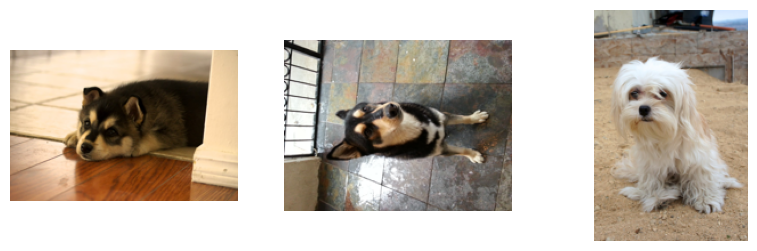

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, img_path in zip(axes, [baby_loyer, big_loyer, flaca]):
    img = Image.open(img_path)
    img.thumbnail((200, 200))  # Resize the image to fit within 200x200 pixels while keeping the aspect ratio
    ax.imshow(img)
    ax.axis('off')

plt.show()

Now lets generate the image embeddings! Here we write a similar function to the text embeddings one to generate the image embeddings.

In [89]:
def generate_image_embeddings(image_path):
    batch_image = [Image.open(image_path)]

    # Process image
    inputs = vit_processor(images=batch_image, return_tensors="pt")

    # Compute image embeddings
    with torch.no_grad():
        outputs = vit_model(**inputs)
        # last_hidden_states = outputs.last_hidden_state
        image_embeddings = outputs.pooler_output

    # Normalize embeddings
    image_embeddings = torch.nn.functional.normalize(image_embeddings, p=2, dim=1)
    return image_embeddings

In [90]:
baby_loyer_emb = generate_image_embeddings(baby_loyer)
big_loyer_emb = generate_image_embeddings(big_loyer)
flaca_emb = generate_image_embeddings(flaca)

In [91]:
print("Length of baby_loyer embedding: ", len(baby_loyer_emb[0]))
print("First 10 elements of baby_loyer embedding: ", baby_loyer_emb[0][:10])

Length of baby_loyer embedding:  768
First 10 elements of baby_loyer embedding:  tensor([ 0.0221,  0.0107, -0.0476, -0.0253, -0.0162,  0.0383,  0.0372,  0.0509,
         0.0079, -0.0446])


In [92]:
baby_big_sim = cos(baby_loyer_emb, big_loyer_emb)
print("Similarity between baby_loyer and big_loyer: ", baby_big_sim.item())

Similarity between baby_loyer and big_loyer:  0.63341224193573


In [93]:
baby_flaca_sim = cos(baby_loyer_emb, flaca_emb)
print("Similarity between baby_loyer and flaca: ", baby_flaca_sim.item())

Similarity between baby_loyer and flaca:  0.47115159034729004


You can see that baby and grown up Loyer have higher similarity that Loyer to my other dog (Flaca). We now have a model capable of generating image embeddings. Nothing too fancy, now lets generate image captions.

## Image Captioning

How can we search for images using text? Image captioning is a way to generate a textual description of an image. Now days we are getting not only text based models but also vision-enabled ones! This makes them very powerful for multimodal applications. 

We will use Groq to generate image captions using the [Llama 3.2 Vision 90B](https://huggingface.co/meta-llama/Llama-3.2-90B-Vision-Instruct). This model is capable of processing both text and images to generate text. I actually tried using the HuggingFace Serverless API but for the life of me I couldn't get it to work. I'm sure it's possible but I couldn't figure it out. Posted on the forums with no luck (if you know how, please comment). I decided to use Groq instead (turned out to be amazing!).

In [96]:
import os
import base64

from groq import Groq

Make sure GROQ_API_KEY environment variable is set with your Groq API key. You can get one by signing up at [Groq](https://console.groq.com/playground).

In [97]:
client = Groq(
    api_key=os.environ["GROQ_API_KEY"]
)

Similar to the text and image embeddings, we will write a function to generate image captions.

In [98]:
def get_image_caption(image_path):
    with open(image_path, "rb") as image_file:
        input_image = base64.b64encode(image_file.read()).decode('utf-8')

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Create a detailed caption for the attached image."}
            ]
        }
    ]

    messages[0]["content"].append(
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{input_image}",
            },
        }
    )

    chat_completion = client.chat.completions.create(
        messages=messages,
        model="llama-3.2-11b-vision-preview",
        temperature=0.5,
        max_tokens=1024,
        top_p=1,
        stream=False,
        stop=None,
    )
    return chat_completion.choices[0].message.content


Now lets generate the image captions for the images we have.

In [99]:
baby_loyer_caption = get_image_caption(baby_loyer)
print("Caption for baby_loyer image: ", baby_loyer_caption)

Caption for baby_loyer image:  The image shows a small, fluffy puppy lying on a wooden floor, with its head resting on a cream-colored mat and its body curled up beside a white column. The puppy has a black and tan coat with distinctive markings around its eyes and muzzle, and its ears are folded back against its head. Its nose is black, and its mouth is slightly open, revealing a few teeth.

The puppy's paws are visible, with the front paws resting on the cream-colored mat and the back paws tucked under its body. The wooden floor is made of medium-brown planks, and the cream-colored mat is placed on top of it, creating a cozy and inviting space for the puppy to rest.

In the background, a white wall is visible, with a white column standing in front of it. The overall atmosphere of the image is one of warmth and comfort, with the puppy's relaxed posture and the soft lighting creating a sense of serenity. The image suggests that the puppy is feeling safe and content in its surroundings,

In [33]:
big_loyer_caption = get_image_caption(big_loyer)
print("Caption for big_loyer image: ", big_loyer_caption)

"The image shows a dog standing on a tiled floor, with its head tilted upwards and its ears perked up. The dog appears to be looking at something above it, possibly a treat or a toy.\n\n* The dog is black and white, with brown markings on its face and legs.\n\t+ It has a distinctive black nose and dark eyes.\n\t+ Its ears are perked up, indicating that it is alert and attentive.\n* The dog is standing on a tiled floor, which is made up of large, square tiles in a mix of colors including gray, brown, and tan.\n\t+ The tiles are arranged in a random pattern, with some of them overlapping each other.\n\t+ The floor appears to be made of ceramic or porcelain, and it is clean and well-maintained.\n* In the background, there is a black metal gate or railing, which is attached to a wall on the left side of the image.\n\t+ The gate is made up of thin, horizontal bars that are spaced evenly apart.\n\t+ It appears to be a decorative element, rather than a functional barrier.\n\nOverall, the imag

In [34]:
flaca_caption = get_image_caption(flaca)
print("Caption for flaca image: ", flaca_caption)

"Here is a detailed caption for the attached image:\n\n[Caption: A small, fluffy white dog with shaggy fur sits on a dirt surface, looking up at the camera.]\n\nThe dog, with its long, curly fur, sits on a dirt surface, gazing up at the camera with its head tilted slightly to the side. Its fur is predominantly white, with a few patches of light brown on its back and legs. The dog's black nose and dark eyes are visible, and its small, black mouth is closed. The dog's long fur covers its eyes, making it difficult to determine their color.\n\nIn the background, a construction site is visible, with a pile of dirt and gravel behind the dog. A wooden platform or foundation is also visible, with various tools and materials scattered about. The sky above is bright and overcast, suggesting a cloudy day."

## Multimodal Database

We have our text embeddings, image embeddings, and image captions. Now we will use LanceDB to create a multimodal database. Why LanceDB? I got to hear from their team and they are doing some amazing work. I am not performing any benchmarks here but the selling point (amognst many others) is that the data itself (images, bytes, etc.) is stored alongside the embeddings and metadata. There is no need to store the data in a separate location. This is a huge advantage for multimodal databases!

We will be able to search for images using text, text using images, images using images, etc. You can search via any combination of text and image. We will keep it simple and only search for images using text and images. We will leave the rest as an exercise for the reader to implement any search combination they want.

In [100]:
import lancedb
import pandas as pd
import pyarrow as pa


Let us instantiate the LanceDB client and create the multimodal database.

We will create it with 5 fields:

- `vector_img`: Image embeddings
- `vector_txt`: Text embeddings
- `text`: Image captions
- `image_name`: The path to the image
- `image`: The image binary itself (go LanceDB!)

In [37]:
db = lancedb.connect("./lance.db")
schema = pa.schema(
    [
        pa.field("vector_img", pa.list_(pa.float32(), list_size=768)),
        pa.field("vector_txt", pa.list_(pa.float32(), list_size=384)),
        pa.field("text", pa.string()),
        pa.field("image_name", pa.string()),
        pa.field("image", pa.binary()),
    ]
)
db.create_table("image_table", schema=schema)
image_table = db.open_table("image_table")


We have created our table, now let us insert some data. For th epurposes of this tutorial we will just make use of the data we have generated so far. It will be simple but gets the point across.

In [42]:
vectors_img = [baby_loyer_emb, big_loyer_emb, flaca_emb]
vector_txt = [get_embedding(caption) for caption in [baby_loyer_caption, big_loyer_caption, flaca_caption]]
texts = [baby_loyer_caption, big_loyer_caption, flaca_caption]
images_paths = [baby_loyer, big_loyer, flaca]
images_as_bytes = [open(img, "rb").read() for img in images_paths]


to_add = [
    {
        "vector_img": vec_img.tolist()[0],
        "vector_txt": vec_txt.tolist()[0],
        "text": txt,
        "image_name": str(img_name),
        "image": img
    } for vec_img, vec_txt, txt, img_name, img in zip(vectors_img, vector_txt, texts, images_paths, images_as_bytes)
]

image_table.add(to_add)

Now we have our multimodal database with text and image embeddings, and image captions. Let's search for images using text and images. Let's write two quick functions to help us search.

In [101]:
def search_images_by_image(image: str) -> pd.DataFrame:
    vector = generate_image_embeddings(image)[0].tolist()
    return image_table.search(vector, vector_column_name='vector_img').to_pandas()

def search_images_by_text(text: str) -> pd.DataFrame:
    vector = get_embedding(text)[0].tolist()
    return image_table.search(vector, vector_column_name='vector_txt').to_pandas()

Notice how we define the `vector_column_name`, this is another powerful feature of LanceDB, you want to store something? Just define it!

We are almost done :( 

Let's get to the fun part and search for images using text and images.

In [64]:
loyer_results = search_images_by_image(baby_loyer)
loyer_results.head()

Since we are using LanceDB, we should be able to simply load the image straight from the database since we store the image binary itself.

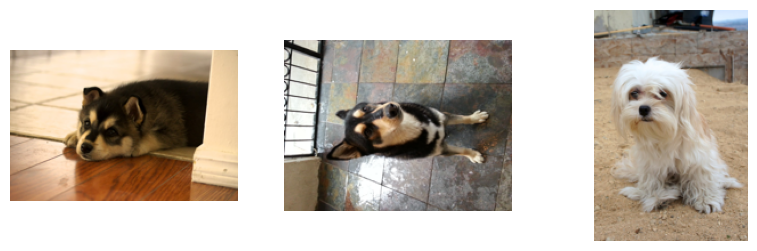

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, (_, row) in zip(axes, loyer_results.iterrows()):
    img = Image.open(io.BytesIO(row["image"]))
    img.thumbnail((200, 200))  # Resize the image to fit within 200x200 pixels while keeping the aspect ratio
    ax.imshow(img)
    ax.axis('off')

plt.show()

Impressive, right? Exactly the ordering we expected.

Now let's search for images using text.

In [70]:
white_dog_results = search_images_by_text("white dog")
white_dog_results.head()

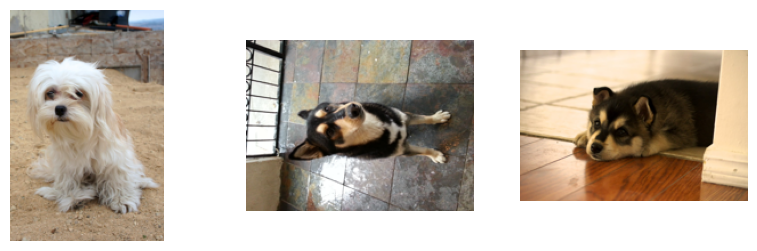

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, (_, row) in zip(axes, white_dog_results.iterrows()):
    img = Image.open(io.BytesIO(row["image"]))
    img.thumbnail((200, 200))  # Resize the image to fit within 200x200 pixels while keeping the aspect ratio
    ax.imshow(img)
    ax.axis('off')

plt.show()

Once again, the exact ordering! 

## Conclusion

We have created a multimodal database with text and image embeddings, and image captions. We were able to search for images using text and images. We used the HuggingFace Hub to download a text and image embedding model, Groq to generate image captions, and LanceDB to create a multimodal database. We hope you found this tutorial helpful and informative. If you have any questions or feedback, please feel free to leave a comment.

Stay tuned, in our next tutorial we will show you how to build a cool multimodal RAG application. Thank you for reading!

